## SPH6004 Assignment 1: Predict the need for intubatation of an ICU patient using clinical data from the MIMIC-IV dataset

### Propose and implement a strategy to select the right features for the predictive model

In [1]:
# Load Assignment_1_data.csv into a Pandas dataframe and display the 5 rows of the data
import pandas as pd
df = pd.read_csv('Assignment_1_data.csv')
df.head()

# Print the number of datapoints and features in the dataframe
print("Number of datapoints:", df.shape[0])
print("Number of features:", df.shape[1])
# Print the number datapoints of each outcome
print(df['outcome'].value_counts())

Number of datapoints: 36489
Number of features: 60
False    35160
True      1329
Name: outcome, dtype: int64


In [2]:
# Remove multiple columns from the dataframe and display the 5 rows of the data
df.drop(['lactate_min','lactate_max',
         'ph_min','ph_max',
         'chloride_min','chloride_max',
         'calcium_min','calcium_max',
         'sodium_min','sodium_max',
         'total_protein_min','total_protein_max',
         'pt_min','pt_max',
         'alt_min','alt_max',
         'alp_min','alp_max',
         'ast_min','ast_max',
         'bilirubin_total_min','bilirubin_total_max',
         'bilirubin_direct_min','bilirubin_direct_max',
         'bilirubin_indirect_min','bilirubin_indirect_max',
         'sofa_respiration','sofa_liver'
         ], axis=1, inplace=True)

print(df.shape)


# Remove rows with missing values
df.dropna(inplace=True)

# Replace "M" and "F" in the "gender" column with 0 and 1
df['gender'] = df['gender'].replace({'M': 0, 'F': 1})
df.head()

# Remove rows where "urineoutput" is a negative value
df = df[df['urineoutput'] >= 0]
print(df.shape)

# get the features names in a list
features = df.columns.tolist()
print(features)

# Print the number datapoints of each outcome
print(df['outcome'].value_counts())


(36489, 32)
(34339, 32)
['gender', 'age', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'temperature_min', 'temperature_max', 'temperature_mean', 'glucose_min', 'glucose_max', 'wbc_min', 'wbc_max', 'creatinine_min', 'creatinine_max', 'hemoglobin_min', 'hemoglobin_max', 'urineoutput', 'sofa_coagulation', 'sofa_cardiovascular', 'sofa_cns', 'sofa_renal', 'charlson_comorbidity_index', 'outcome']
False    33062
True      1277
Name: outcome, dtype: int64


In [3]:
# Correct the dataset imbalance using SMOTE to oversample the minority class (outcome = 1)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X = df.drop('outcome', axis=1)
y = df['outcome']
X_res, y_res = sm.fit_resample(X, y)
print(X_res.shape)

# Print the number datapoints of each outcome in y_res
print(pd.Series(y_res).value_counts())

# Save the normalized and balanced dataset to a csv file
df_new = pd.concat([X_res, y_res], axis=1)
# df_new.to_csv('Assignment_1_data_new.csv', index=False)

(66124, 31)
False    33062
True     33062
Name: outcome, dtype: int64


In [4]:
# Remove all the rows with feature values that are outside of the 0.3th and 99.7th percentile
for feature in features:
    if feature != 'outcome':
        df_new = df_new[df_new[feature] <= df_new[feature].quantile(0.997)]
        df_new = df_new[df_new[feature] >= df_new[feature].quantile(0.003)]
print(df_new.shape)

# Print the number datapoints of each outcome
print(df_new['outcome'].value_counts())

(57001, 32)
True     29972
False    27029
Name: outcome, dtype: int64


In [6]:
# Normalize all the features except the gender and outcome
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_new[features[1:-1]] = scaler.fit_transform(df_new[features[1:-1]])
df_new.head()

,gender,age,heart_rate_min,heart_rate_max,heart_rate_mean,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,...,creatinine_max,hemoglobin_min,hemoglobin_max,urineoutput,sofa_coagulation,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
0,0,0.454833,0.7125,0.477876,0.673693,0.540230,0.159807,0.470187,0.385566,0.521368,...,0.151098,0.360360,0.182859,0.496974,0.000000,0.25,0.00,0.25,0.200000,False
1,0,0.886963,0.1750,0.000000,0.017787,0.586207,0.124849,0.271816,0.473342,0.333333,...,0.127853,0.693694,0.629849,0.289625,0.294697,0.25,0.25,0.25,0.533333,False
2,0,0.260622,0.4250,0.389381,0.406014,0.643678,0.119855,0.361677,0.462370,0.230769,...,0.034869,0.180180,0.000000,0.438040,0.294697,0.25,0.25,0.00,0.266667,False
3,0,0.710964,0.4000,0.327434,0.411953,0.735632,0.164801,0.505433,0.341678,0.393162,...,0.139475,0.621622,0.579055,0.227954,0.000000,0.00,0.00,0.25,0.400000,False
4,0,0.674804,0.5125,0.300885,0.437186,0.229885,0.109867,0.109374,0.001545,0.230769,...,0.418426,0.477477,0.568896,0.047406,0.000000,1.00,0.25,0.75,0.666667,False


In [7]:
# Create a train and test set using all 32 features (this is for creating a baseline model)
from sklearn.model_selection import train_test_split
X = df_new.drop('outcome', axis=1)
y = df_new['outcome']
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Perform feature selection using Elastic Net Regression
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel

X, y = df_new.drop(['outcome'], axis=1), df_new['outcome']

# Train an Elastic Net regression model
clf = ElasticNet(alpha=4e-3, l1_ratio=0.5)
clf.fit(X, y)

# Use SelectFromModel with Elastic Net
selector = SelectFromModel(clf, prefit=True)

# Print the selected feature indices
selected_features = selector.get_support(indices=True)
print("Selected features (refer to the corresponding indices in Table the report for the feature names): ", selected_features)

X_selected = selector.transform(X)
X_selected.shape


Selected features:  [ 0  2  8 11 16 25 28]


/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(57001, 7)

### Implement predictive models using the selected features

In [9]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [10]:
# Import the necessary libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt


### Logistic Regression

Accuracy:  0.7518638715902114
Confusion matrix:  [[3904 1428]
 [1401 4668]]


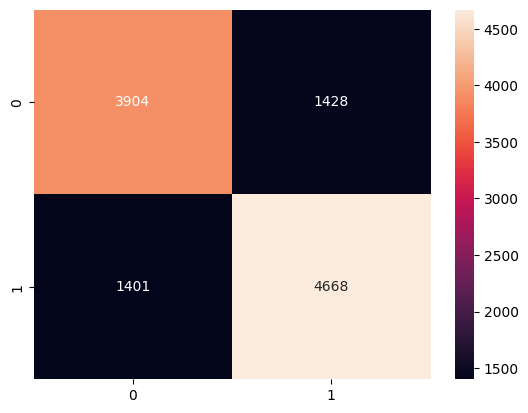

Precision score:  0.765748031496063
Recall score:  0.7691547207118141
F1 score:  0.7674475955610357
AUROC score:  0.7506688832366273


In [24]:
# Implement a baseline logistic regression model using all the features
lr = LogisticRegression(max_iter=150)
lr.fit(X_base_train, y_base_train)

# Predict the outcome using the test set
y_base_pred = lr.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print("Accuracy: ", accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))

Accuracy:  0.7458117708972897
Confusion matrix:  [[3870 1462]
 [1436 4633]]


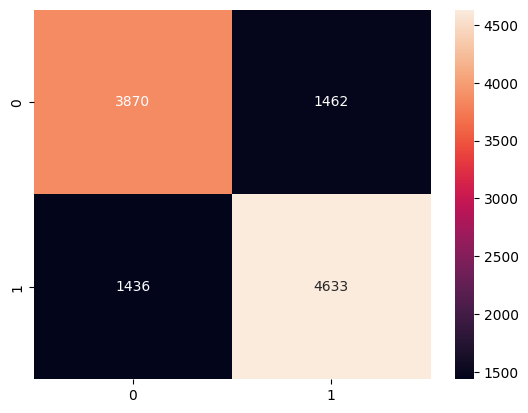

Precision score:  0.7601312551271534
Recall score:  0.7633877080243863
F1 score:  0.7617560013153568
AUROC score:  0.7445970798186448


In [25]:
# Implement a logistic regression model using the selected features
lr = LogisticRegression(max_iter=150)
lr.fit(X_train, y_train)

# Predict the outcome for the test set
y_pred = lr.predict(X_test)

# Print the accuracy, precision, recall and F1 scores
print("Accuracy: ", accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_test, y_pred))

Accuracy score:  0.7450223664590825
Confusion matrix:  [[3864 1468]
 [1439 4630]]


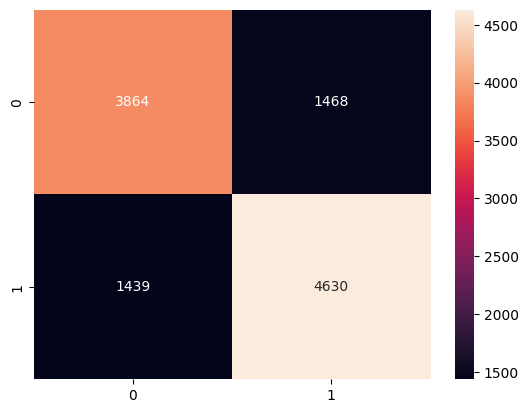

Precision score:  0.7592653328960315
Recall score:  0.7628933926511782
F1 score:  0.7610750390400264
AUROC score:  0.7437872814718756


In [26]:
# Train a logistic regression model with Elastic Net regularization
logreg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.1, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict the outcome of the test set
y_pred = logreg.predict(X_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_test, y_pred))

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.581631  2.96      0.004813]	[ 0.052657  1.248359  0.002243]	[ 0.524189  1.        0.000054]	[ 0.751425  5.        0.011393]
1  	29    	[-2399.527703     3.82      2400.0036  ]	[ 4271.096709     2.1697    4270.829278]	[-10000.            1.            0.001799]	[     0.752061      9.        10000.      ]
2  	22    	[-999.390585    3.06     1000.00363 ]   	[ 3000.203139     1.678213  2999.99879 ]	[-10000.            1.            0.001465]	[     0.752061      7.        10000.      ]
3  	29    	[ 0.725779  2.06      0.004044]         	[ 0.051629  1.066021  0.00151 ]         	[ 0.552368  1.        0.001465]            	[ 0.752061  5.        0.012048]            
4  	30    	[ 0.750152  1.92      0.004145]         	[ 0.003816  1.016661  0.000412]         	[ 0.736338  1.        0.002925]            

/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


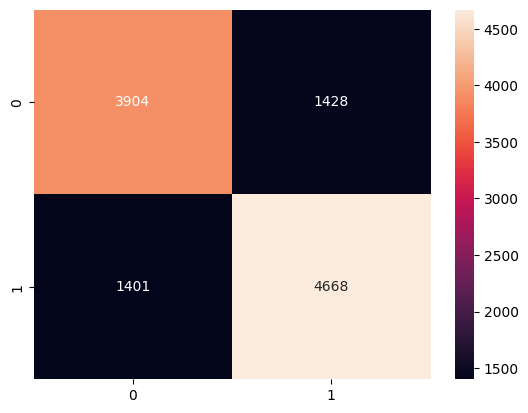

Precision score:  0.8101041871436996
Recall score:  0.6790245509968693
F1 score:  0.7387952671208318
AUROC score:  0.7506688832366273


In [36]:
# Train a logistic regression model with GeneticSelectionCV
from genetic_selection import GeneticSelectionCV

logreg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.1, max_iter=1000)
selector = GeneticSelectionCV(logreg,
                                cv=5,
                                verbose=1,
                                scoring="accuracy",
                                max_features=5,
                                n_population=50,
                                crossover_proba=0.5,
                                mutation_proba=0.2,
                                n_generations=40,
                                crossover_independent_proba=0.5,
                                mutation_independent_proba=0.05,
                                tournament_size=3,
                                n_gen_no_change=10,
                                caching=True,
                                n_jobs=-2)

selectors = selector.fit(X_base_train, y_base_train)

# Print the features names selected by GeneticSelectionCV
print('Features selected by GeneticSelectionCV: ', X_base_train.columns[selectors.support_])

# Predict the outcome of the test set
y_pred = selector.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))


### Decision Tree Classifier

Accuracy score:  0.9436891500745549
Confusion matrix:  [[5103  229]
 [ 413 5656]]


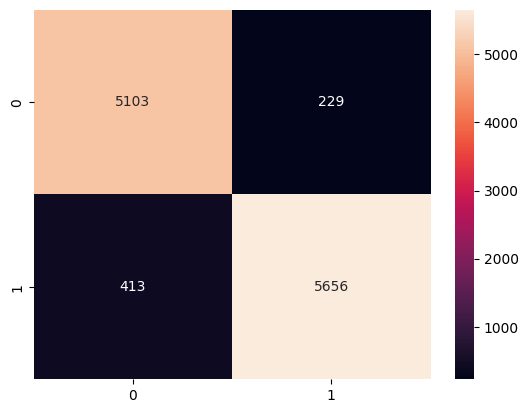

Precision score:  0.9610875106202209
Recall score:  0.9319492502883506
F1 score:  0.9462941274887066
AUROC score:  0.9445005066145429


In [14]:
# Train a decision tree classifier using all 32 features

dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_base_train, y_base_train)

# Predict the outcome of the test set
y_base_pred = dt.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))

Accuracy score:  0.9351811244627665
Confusion matrix:  [[4939  393]
 [ 346 5723]]


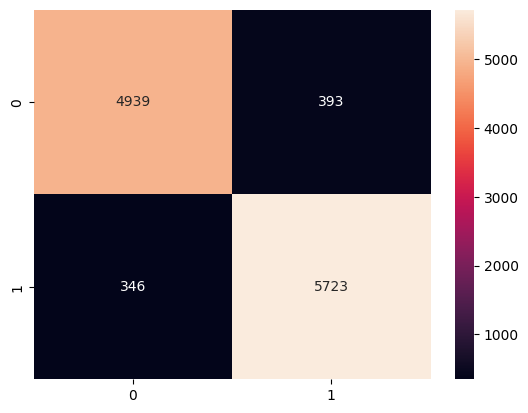

Precision score:  0.9357423152387181
Recall score:  0.9429889602899983
F1 score:  0.9393516618793599
AUROC score:  0.934641516904189


In [19]:
# Train a decision tree classifier using the features selected by Elastic Net
dt = DecisionTreeClassifier(max_depth=20, random_state=42)
dt.fit(X_train, y_train)

# Predict the outcome of the test set
y_pred = dt.predict(X_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_test, y_pred))

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.7604    2.7       0.008046]	[ 0.110835  1.526434  0.01066 ]	[ 0.547566  1.        0.000884]	[ 0.936776  5.        0.051659]
1  	32    	[-1599.297044     3.82      1600.004355]	[ 3666.367352     1.935872  3666.058655]	[-10000.           0.           0.00084]	[     0.936776     10.        10000.      ]
2  	25    	[-999.209385    4.12     1000.003212]   	[ 3000.263539     1.423236  2999.998929]	[-10000.           1.           0.00084]	[     0.950482      8.        10000.      ]
3  	33    	[-1599.225422     4.44      1600.00198 ]	[ 3666.398609     1.298615  3666.059692]	[-10000.            2.            0.000717]	[     0.961184      8.        10000.      ]
4  	34    	[-999.152049    4.22     1000.001791]   	[ 3000.28265      1.171153  2999.999403]	[-10000.            2.            0.000717]	[    

/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


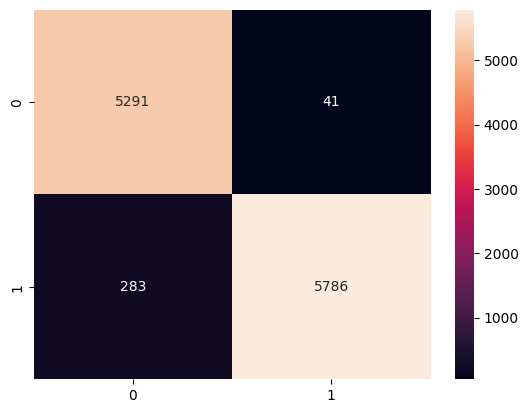

Precision score:  0.9929637892569075
Recall score:  0.9533695831273686
F1 score:  0.972763954270343
AUROC score:  0.9728400803858898


In [58]:
# Train a decision tree classifier using GeneticSelectionCV
from genetic_selection import GeneticSelectionCV

dt = DecisionTreeClassifier(max_depth=20, random_state=42)
selector = GeneticSelectionCV(dt,
                              cv=5,
                              verbose=1,
                              scoring="accuracy",
                              max_features=5,
                              n_population=50,
                              crossover_proba=0.5,
                              mutation_proba=0.2,
                              n_generations=40,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,
                              tournament_size=3,
                              n_gen_no_change=10,
                              caching=True,
                              n_jobs=-2)

selectors = selector.fit(X_base_train, y_base_train)

# Print the features names selected by GeneticSelectionCV
print('Features selected by GeneticSelectionCV: ', X_base_train.columns[selectors.support_])

# Predict the outcome of the test set
y_base_pred = selector.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))


### Random Forest Classifier

Accuracy score:  0.9733356723094465
Confusion matrix:  [[5185  147]
 [ 157 5912]]


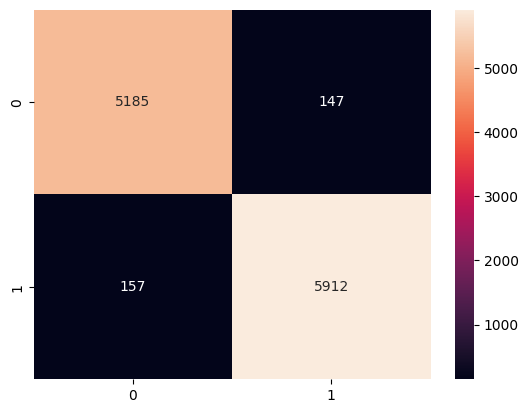

Precision score:  0.9757385707212411
Recall score:  0.9741308288021091
F1 score:  0.974934036939314
AUROC score:  0.9732807182270111


In [23]:
# Train a random forest classifier using all 32 features
rf = RandomForestClassifier(n_estimators=15, max_depth=20, random_state=42)
rf.fit(X_base_train, y_base_train)

# Predict the outcome of the test set
y_base_pred = rf.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))

Accuracy score:  0.9533374265415314
Confusion matrix:  [[5099  233]
 [ 299 5770]]


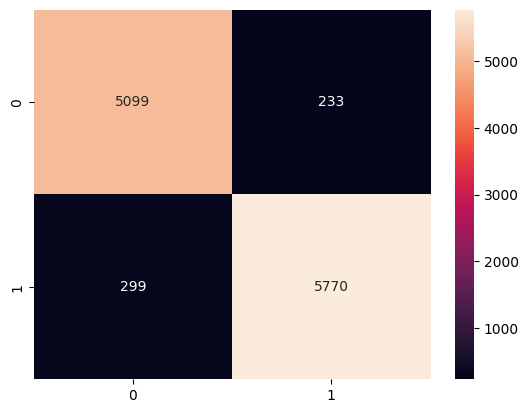

Precision score:  0.9611860736298518
Recall score:  0.9507332344702587
F1 score:  0.9559310801855533
AUROC score:  0.9535174049320536


In [28]:
# Train a random forest classifier using the features selected by Elastic Net
rf = RandomForestClassifier(n_estimators=15, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# Predict the outcome of the test set
y_pred = rf.predict(X_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_test, y_pred))


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.821958  3.08      0.00756 ]	[ 0.084451  1.411949  0.007052]	[ 0.594781  1.        0.001275]	[ 0.950987  5.        0.036629]
1  	21    	[-399.134389    3.88      400.004491]	[ 1959.768487     1.21062   1959.590878]	[-10000.            1.            0.001275]	[     0.956974      6.        10000.      ]
2  	37    	[-1999.2659       4.12      2000.003255]	[ 4000.36705      1.595494  3999.998373]	[-10000.            2.            0.000853]	[     0.965636      7.        10000.      ]
3  	20    	[-799.146405    3.94      800.00282 ]   	[ 2713.183705     1.255548  2712.931162]	[-10000.            2.            0.000642]	[     0.965636      7.        10000.      ]
4  	29    	[-399.087651    3.82      400.00184 ]   	[ 1959.778027     1.194822  1959.591419]	[-10000.            2.            0.000642]	[ 

/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


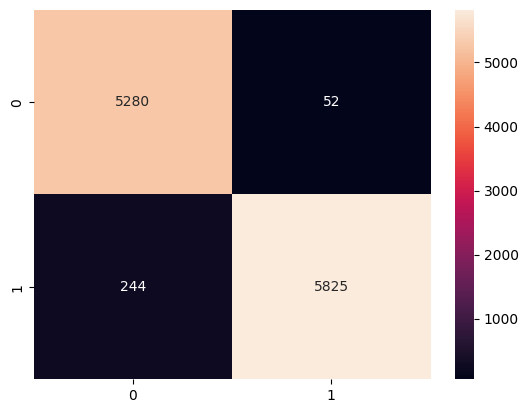

Precision score:  0.9911519482729284
Recall score:  0.959795682979074
F1 score:  0.9752218315754229
AUROC score:  0.9750216224347732


In [32]:
# Train a random forest classifier using GeneticSelectionCV
from genetic_selection import GeneticSelectionCV

rf = RandomForestClassifier(n_estimators=15, max_depth=20, random_state=42)
selector = GeneticSelectionCV(rf,
                              cv=5,
                              verbose=1,
                              scoring="accuracy",
                              max_features=5,
                              n_population=50,
                              crossover_proba=0.5,
                              mutation_proba=0.2,
                              n_generations=40,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,
                              tournament_size=3,
                              n_gen_no_change=10,
                              caching=True,
                              n_jobs=-2)

selectors = selector.fit(X_base_train, y_base_train)

# Print the features names selected by GeneticSelectionCV
print('Features selected by GeneticSelectionCV: ', X_base_train.columns[selectors.support_])

# Predict the outcome of the test set
y_base_pred = selector.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))


### Gradient Boosting Classifier

Accuracy score:  0.9590386808174721
Confusion matrix:  [[5084  248]
 [ 219 5850]]


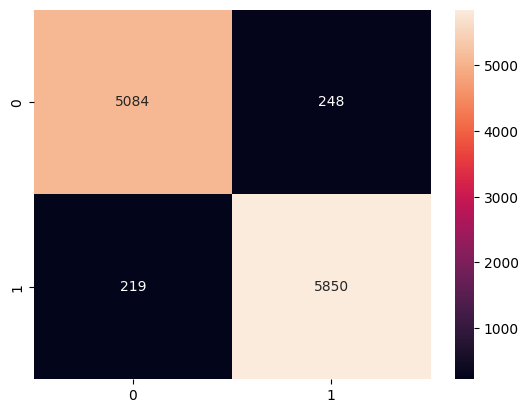

Precision score:  0.9593309281731716
Recall score:  0.9639149777558083
F1 score:  0.9616174899317826
AUROC score:  0.9587016749244158


In [36]:
# Train a gradient boosting classifier using all 32 features
gb = GradientBoostingClassifier(n_estimators=15, max_depth=20, random_state=42)
gb.fit(X_base_train, y_base_train)

# Predict the outcome of the test set
y_base_pred = gb.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))


# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))

Accuracy score:  0.9427243224278572
Confusion matrix:  [[4970  362]
 [ 291 5778]]


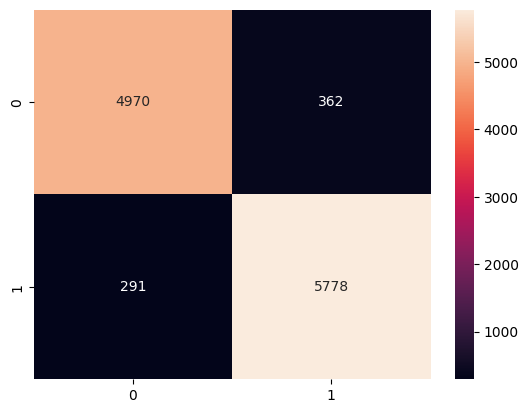

Classification report:                precision    recall  f1-score   support

       False       0.94      0.93      0.94      5332
        True       0.94      0.95      0.95      6069

    accuracy                           0.94     11401
   macro avg       0.94      0.94      0.94     11401
weighted avg       0.94      0.94      0.94     11401

Precision score:  0.9410423452768729
Recall score:  0.9520514087988137
F1 score:  0.9465148660823982
AUROC score:  0.9420797179027827


In [40]:
# Train a gradient boosting classifier using the features selected by Elastic Net
gb = GradientBoostingClassifier(n_estimators=15, max_depth=20, random_state=42)
gb.fit(X_train, y_train)

# Predict the outcome of the test set
y_pred = gb.predict(X_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_test, y_pred))

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.857015  2.72      0.008041]	[ 0.101106  1.483779  0.006598]	[ 0.556053  1.        0.001609]	[ 0.950987  5.        0.027828]
1  	29    	[-999.174254    3.88     1000.003652]	[ 3000.275249     1.36587   2999.998783]	[-10000.            1.            0.000922]	[     0.958925      7.        10000.      ]
2  	38    	[-1999.249921     4.14      2000.002772]	[ 4000.37504      1.67344   3999.998614]	[-10000.            2.            0.000774]	[     0.964693     10.        10000.      ]
3  	26    	[-599.112179    3.44      600.003283]   	[ 2375.092722     1.32906   2374.867588]	[-10000.            1.            0.000729]	[     0.964693      7.        10000.      ]
4  	27    	[-399.089865    3.12      400.002716]   	[ 1959.777575     1.088853  1959.59124 ]	[-10000.            1.            0.000632]	[ 

/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


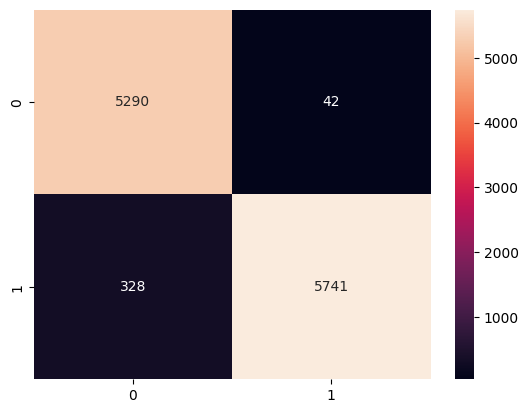

Precision score:  0.9927373335638942
Recall score:  0.945954852529247
F1 score:  0.9687816402294972
AUROC score:  0.9690389416434682


In [43]:
# Train a gradient boosting classifier using GeneticSelectionCV
gb = GradientBoostingClassifier(n_estimators=15, max_depth=20, random_state=42)
selector = GeneticSelectionCV(gb,
                              cv=5,
                              verbose=1,
                              scoring="accuracy",
                              max_features=5,
                              n_population=50,
                              crossover_proba=0.5,
                              mutation_proba=0.2,
                              n_generations=40,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,
                              tournament_size=3,
                              n_gen_no_change=10,
                              caching=True,
                              n_jobs=-2)

selectors = selector.fit(X_base_train, y_base_train)

# Print the features names selected by GeneticSelectionCV
print('Features selected by GeneticSelectionCV: ', X_base_train.columns[selectors.support_])

# Predict the outcome of the test set
y_base_pred = selector.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))

### Adaptive Boosting Classifier

Accuracy score:  0.8846592404175072
Confusion matrix:  [[4623  709]
 [ 606 5463]]


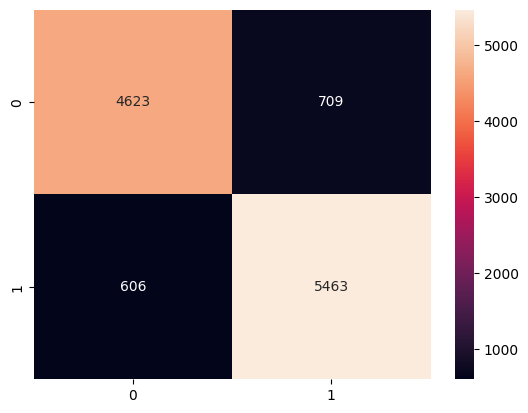

Precision score:  0.8851263771872975
Recall score:  0.9001482946119624
F1 score:  0.8925741360999918
AUROC score:  0.8835887759631454


In [46]:
# Train an adaptive boosting classifier using all 32 features
ab = AdaBoostClassifier(n_estimators=15, random_state=42)
ab.fit(X_base_train, y_base_train)

# Predict the outcome of the test set
y_base_pred = ab.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))

Accuracy score:  0.8593105867906324
Confusion matrix:  [[4278 1054]
 [ 550 5519]]


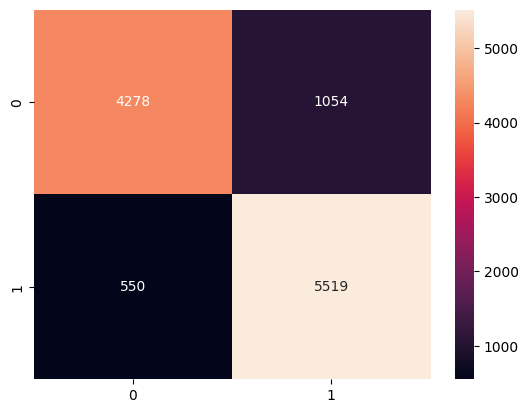

Precision score:  0.8396470409249962
Recall score:  0.9093755149118471
F1 score:  0.8731213415598799
AUROC score:  0.855850548153598


In [50]:
# Train an adaptive boosting classifier using the features selected by Elastic Net
ab = AdaBoostClassifier(n_estimators=15, random_state=42)
ab.fit(X_train, y_train)

# Predict the outcome of the test set
y_pred = ab.predict(X_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_test, y_pred))

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.682597  3.1       0.006762]	[ 0.100493  1.360147  0.005264]	[ 0.545241  1.        0.001405]	[ 0.874232  5.        0.025823]
1  	31    	[-1399.348522     4.14      1400.005251]	[ 3470.13317      1.510099  3469.868196]	[-10000.            1.            0.002137]	[     0.874232      7.        10000.      ]
2  	24    	[-599.225       4.28      600.004046]   	[ 2375.064219     1.265543  2374.867395]	[-10000.            1.            0.002138]	[     0.885461      7.        10000.      ]
3  	27    	[-1399.248762     4.58      1400.003576]	[ 3470.173419     1.342982  3469.868872]	[-10000.            2.            0.002176]	[     0.885461      9.        10000.      ]
4  	27    	[-1399.246493     4.58      1400.003928]	[ 3470.174335     1.184736  3469.86873 ]	[-10000.            2.            0.002176]

/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


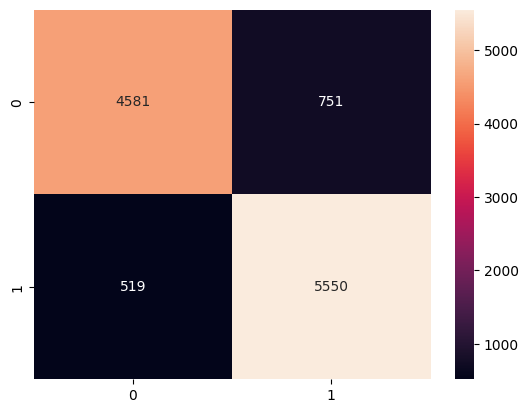

Precision score:  0.8808125694334232
Recall score:  0.9144834404349975
F1 score:  0.8973322554567502
AUROC score:  0.8868178642535078


In [53]:
# Train a gradient boosting classifier using GeneticSelectionCV
ab = AdaBoostClassifier(n_estimators=15, random_state=42)
selector = GeneticSelectionCV(ab,
                              cv=5,
                              verbose=1,
                              scoring="accuracy",
                              max_features=5,
                              n_population=50,
                              crossover_proba=0.5,
                              mutation_proba=0.2,
                              n_generations=40,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,
                              tournament_size=3,
                              n_gen_no_change=10,
                              caching=True,
                              n_jobs=-2)

selectors = selector.fit(X_base_train, y_base_train)

# Print the features names selected by GeneticSelectionCV
print('Features selected by GeneticSelectionCV: ', X_base_train.columns[selectors.support_])

# Predict the outcome of the test set
y_base_pred = selector.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))

### Support Vector Machine Classifier

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................................C=0.1, gamma=1; total time= 1.0min
[CV] END .....................................C=0.1, gamma=1; total time=  55.6s
[CV] END .....................................C=0.1, gamma=1; total time=  53.3s
[CV] END .....................................C=0.1, gamma=1; total time=  53.0s
[CV] END .....................................C=0.1, gamma=1; total time=  53.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=  59.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=  59.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=  59.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=  59.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=  59.2s
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.2min
[CV] END ..................................C=0.1,

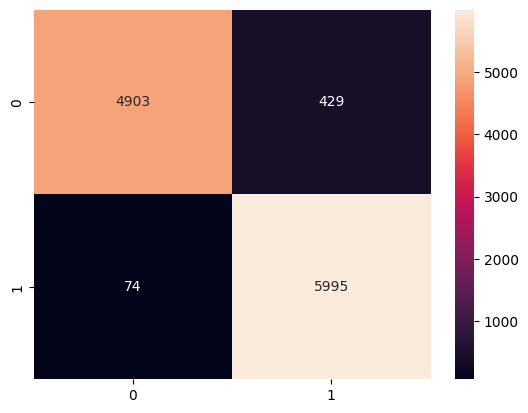

Precision score:  0.9332191780821918
Recall score:  0.9878068874608666
F1 score:  0.9597374529736652
AUROC score:  0.9536746365286328


In [65]:
# Train a support vector machine classifier using all 32 features (C and gamma are tuned using GridSearchCV)
from sklearn.model_selection import GridSearchCV
svc = SVC(kernel='rbf', random_state=42)
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]}
grid = GridSearchCV(svc, param_grid, refit=True, verbose=2)
grid.fit(X_base_train, y_base_train)

# Print the best parameters
print('Best parameters: ', grid.best_params_)

# Predict the outcome of the test set
y_base_pred = grid.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................................C=0.1, gamma=1; total time=  28.7s
[CV] END .....................................C=0.1, gamma=1; total time=  28.4s
[CV] END .....................................C=0.1, gamma=1; total time=  28.3s
[CV] END .....................................C=0.1, gamma=1; total time=  28.4s
[CV] END .....................................C=0.1, gamma=1; total time=  28.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=  29.9s
[CV] END ...................................C=0.1, gamma=0.1; total time=  30.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=  30.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=  30.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=  30.4s
[CV] END ..................................C=0.1, gamma=0.01; total time=  34.5s
[CV] END ..................................C=0.1,

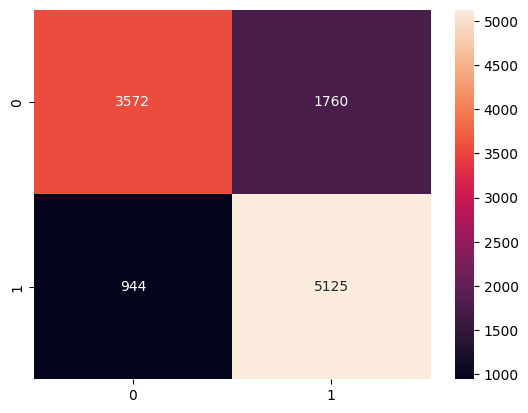

AUROC score:  0.7571864543001792


In [62]:
# Train a support vector machine classifier using features selected by Elastic Net (C and gamma are tuned using GridSearchCV) 
from sklearn.model_selection import GridSearchCV
svc = SVC(kernel='rbf', random_state=42)
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]}
grid = GridSearchCV(svc, param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Print the best parameters
print('Best parameters: ', grid.best_params_)

# Predict the outcome of the test set
y_pred = grid.predict(X_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_test, y_pred))

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.614617  3.2       0.004093]	[ 0.052841  1.456022  0.001319]	[ 0.527281  1.        0.001884]	[ 0.754518  5.        0.007983]
1  	36    	[-2199.476772     4.46      2200.003054]	[ 4142.740914     1.329812  4142.461414]	[-10000.            2.            0.001824]	[     0.755461      7.        10000.      ]
2  	33    	[-1199.377607     4.32      1200.003652]	[ 3249.845196     1.271849  3249.614013]	[-10000.            1.            0.001824]	[     0.761447      8.        10000.      ]
3  	34    	[-1999.415104     4.52      2000.003171]	[ 4000.292448     1.299846  3999.998414]	[-10000.            1.            0.001824]	[     0.761447      7.        10000.      ]
4  	34    	[-1799.384921     4.44      1800.003705]	[ 3842.16272      1.458218  3841.872806]	[-10000.            1.            0.001824]

/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/utils/metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
/home/haozhe/anaconda3/envs/sph6004/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


Accuracy score:  0.760810455223226
Confusion matrix:  [[3630 1702]
 [1025 5044]]


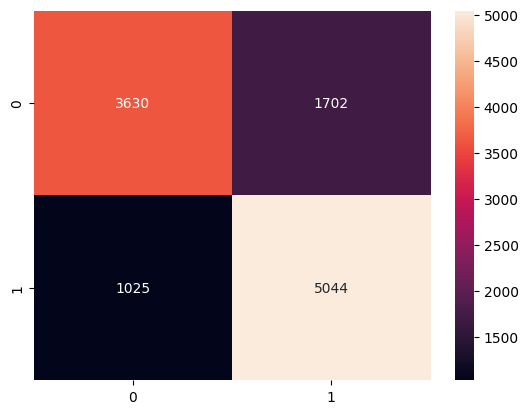

Precision score:  0.7477023421286688
Recall score:  0.8311089141538969
F1 score:  0.7872024970737416
AUROC score:  0.7559520564767983


In [66]:
# Train a gradient boosting classifier using GeneticSelectionCV
svc = svc = SVC(C=10, gamma=1, kernel='rbf', random_state=42)
selector = GeneticSelectionCV(svc,
                              cv=5,
                              verbose=1,
                              scoring="accuracy",
                              max_features=5,
                              n_population=50,
                              crossover_proba=0.5,
                              mutation_proba=0.2,
                              n_generations=40,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,
                              tournament_size=3,
                              n_gen_no_change=10,
                              caching=True,
                              n_jobs=-2)

selectors = selector.fit(X_base_train, y_base_train)

# Print the features names selected by GeneticSelectionCV
print('Features selected by GeneticSelectionCV: ', X_base_train.columns[selectors.support_])

# Predict the outcome of the test set
y_base_pred = selector.predict(X_base_test)

# Print the accuracy, precision, recall and F1 scores
print('Accuracy score: ', accuracy_score(y_base_test, y_base_pred))
print('Precision score: ', precision_score(y_base_test, y_base_pred))
print('Recall score: ', recall_score(y_base_test, y_base_pred))
print('F1 score: ', f1_score(y_base_test, y_base_pred))

# Print and plot the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_base_test, y_base_pred))
sns.heatmap(confusion_matrix(y_base_test, y_base_pred), annot=True, fmt='d')
plt.show()

# Print the AUROC score
print('AUROC score: ', roc_auc_score(y_base_test, y_base_pred))